# [Filtering VQE](https://arxiv.org/abs/2106.10055) - a Quantum Heuristic for solving VRP

### **Theory**

The aim of this notebook is to implement the Filtering VQE algorithm for solving the VRP. We will not here explain all the algorithm, so just refer to [the original article](https://arxiv.org/abs/2106.10055) to understand it properly. Essentially, a regular VQE would use the expectation value of a hamiltonian $H$ on a quantum parametriced circuit in order to try and minimize that expectation value. What the Filtering VQE will do is use that parametriced circuit in order to approximate the action of some operator $F_\tau = f(H, \tau)$ that effectively projects a given wavefunction into lower energy eigenstates, thus, filtering the higher energy eigenstates.




Here, we will not cover how the VRP is formulated and solved in detail, since that is already exposed on [the Qiskit tutorial on the VRP](https://qiskit.org/documentation/tutorials/optimization/7_examples_vehicle_routing.html). However, we add an little summary of the used notation


---
Mathematically speaking, the vehicle routing problem (VRP) is a combinatorial problem, wherein the best routes from a depot to a number of clients and back to the depot are sought, given a number of available vehicles. There are a number of formulations possible, extending a number of formulations of the traveling salesman problem [Applegate et al, 2006]. Here, we present a formulation known as MTZ [Miller, Tucker, Zemlin, 1960]. 

Let $n$ be the number of clients (indexed as $1,\dots,n$), and $K$ be the number of available vehicles. Let $x_{ij} = \{0,1\}$ be the binary decision variable which, if it is $1$, activates the segment from node $i$ to node $j$. The node index runs from $0$ to $n$, where $0$ is (by convention) the depot. There are twice as many distinct decision variables as edges. For example, in a fully connected graph, there are $n(n+1)$ binary decision variables. 

If two nodes $i$ and $j$ have a link from $i$ to $j$, we write $i \sim j$. We also denote with $\delta(i)^+$ the set of nodes to which $i$ has a link, i.e., $j \in \delta(i)^+$ if and only if $i \sim j$. Similarly, we denote with 
$\delta(i)^-$ the set of nodes which are connected to $i$, in the sense that $j \in \delta(i)^-$ if and only if $j \sim i$. 
---



Thus, there will be a variable $x_{ij}$ that will tell if there is a vehicle going from node $i$ to node $j$. Our way to obtain a solution is to consider a vector ${\bf z}$ containing all that information

$$
{\bf z} = [x_{01},x_{02},\ldots,x_{10}, x_{12},\ldots,x_{n(n-1)}]^T,
$$

and, as $x_{ij}$ is a binary variable, that vector can be identified as a bitstring. This is why it makes sense to try and map the problem into a QUBO and then into an Ising Hamiltonian (it's diagonal); our solution can be depicted as one of the eigenstates that will, in fact, be one of the computational basis states.

In a very simple exercise, imagine that we are given the solution
$$
{\bf z} = [x_{01},x_{10}]^T = [1,1]^T,
$$
Thus, $x_{01}=1$ means that there is a vehicle going from the depot to node $1$ and $x_{10}=1$ means that there is a vehicle going from node $1$ to the depot. There are no more variables and that means that there is only $K=1$ vehicle visiting a single depot. Quite a trivial example.

In [1]:
!pip install cplex

You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.


In [3]:
!pip install numpy

You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.


In [147]:
!pip install matplotlib 

You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.


In [148]:
!pip install pandas

You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.


In [149]:
!pip install qiskit

You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.


In [150]:
!pip install qiskit_optimization


You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os.path
from time import process_time 
# Visualization tool
from qiskit.visualization import *
import matplotlib.pyplot as plt
import matplotlib.axes as axes

import itertools
import pandas as pd
import networkx as nx
import time
import math
import cplex
from cplex.exceptions import CplexError
from docplex.mp.model import Model

from qiskit.algorithms.optimizers import ADAM, CG, GSLS, NELDER_MEAD, NFT, POWELL, SPSA, TNC, COBYLA, L_BFGS_B, SLSQP, AQGD, P_BFGS, GradientDescent
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, Aer, transpile, execute
from qiskit.utils  import QuantumInstance, algorithm_globals
from qiskit.circuit import ParameterVector
from qiskit.opflow import Z, I, X, Y, ListOp, PauliExpectation, CVaRExpectation, StateFn, CircuitSampler, CircuitStateFn, ListOp

from qiskit.algorithms import VQE, QAOA

In [3]:
from qiskit import BasicAer
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.algorithms import MinimumEigenOptimizer

## We have defined 3 classes:
**Class Initializer**
GenerateInstance : This method initializes the variables i.e. the number of nodes(including the depot)-n  and number of vehicles-K  
**Class ClassicalOptimizer**
For a classical solution, we use IBM ILOG CPLEX. CPLEX is able to find the exact solution of this problem. We first define a ClassicalOptimizer class that encodes the problem in a way that CPLEX can solve, and then instantiate the class and solve it.

**Class QuantumOptimizer**
1-binary_representation : encodes the problem (M) into a QP terms (that’s basically linear algebra); construct_problem : constructs a  optimization problem as an instance of QuadraticProgram

2-construct_problem : constructs a QUBO optimization problem as an instance of QuadraticProgram


In [104]:
n=int (input("Number of locations: "))
K=int (input("Number of vehicles: "))

Number of locations:  79
Number of vehicles:  78


 ## Initializing our Vehicle Routing Problem

In [105]:
# Get the data
class Initializer:
    def __init__(self, n):
        self.n = n

    def generate_instance(self):

        n = self.n

        np.random.seed(33)
        

        xc = (np.random.rand(n) - 0.5) * 10
        yc = (np.random.rand(n) - 0.5) * 10

        instance = np.zeros([n, n])
        for ii in range(0, n):
            for jj in range(ii + 1, n):
                instance[ii, jj] = (xc[ii] - xc[jj]) ** 2 + (yc[ii] - yc[jj]) ** 2
                instance[jj, ii] = instance[ii, jj]
            return xc, yc, instance

In [106]:
# Initialize the problem by randomly generating the instance
initializer = Initializer(n)
xc, yc, instance = initializer.generate_instance()

In [107]:

class ClassicalOptimizer:
    def __init__(self, instance, n, K):

        self.instance = instance
        self.n = n  # number of nodes
        self.K = K  # number of vehicles

    def compute_allowed_combinations(self):
        f = math.factorial
        return f(self.n) / f(self.K) / f(self.n - self.K)

    def cplex_solution(self):

        # refactoring
        instance = self.instance
        n = self.n
        K = self.K

        my_obj = list(instance.reshape(1, n**2)[0]) + [0.0 for x in range(0, n - 1)]
        my_ub = [1 for x in range(0, n**2 + n - 1)]
        my_lb = [0 for x in range(0, n**2)] + [0.1 for x in range(0, n - 1)]
        my_ctype = "".join(["I" for x in range(0, n**2)]) + "".join(
            ["C" for x in range(0, n - 1)]
        )

        my_rhs = (
            2 * ([K] + [1 for x in range(0, n - 1)])
            + [1 - 0.1 for x in range(0, (n - 1) ** 2 - (n - 1))]
            + [0 for x in range(0, n)]
        )
        my_sense = (
            "".join(["E" for x in range(0, 2 * n)])
            + "".join(["L" for x in range(0, (n - 1) ** 2 - (n - 1))])
            + "".join(["E" for x in range(0, n)])
        )

        try:
            my_prob = cplex.Cplex()
            self.populatebyrow(my_prob, my_obj, my_ub, my_lb, my_ctype, my_sense, my_rhs)

            my_prob.solve()

        except CplexError as exc:
            print(exc)
            return

        x = my_prob.solution.get_values()
        x = np.array(x)
        cost = my_prob.solution.get_objective_value()

        return x, cost

    def populatebyrow(self, prob, my_obj, my_ub, my_lb, my_ctype, my_sense, my_rhs):

        n = self.n

        prob.objective.set_sense(prob.objective.sense.minimize)
        prob.variables.add(obj=my_obj, lb=my_lb, ub=my_ub, types=my_ctype)

        prob.set_log_stream(None)
        prob.set_error_stream(None)
        prob.set_warning_stream(None)
        prob.set_results_stream(None)

        rows = []
        for ii in range(0, n):
            col = [x for x in range(0 + n * ii, n + n * ii)]
            coef = [1 for x in range(0, n)]
            rows.append([col, coef])

        for ii in range(0, n):
            col = [x for x in range(0 + ii, n**2, n)]
            coef = [1 for x in range(0, n)]

            rows.append([col, coef])

        # Sub-tour elimination constraints:
        for ii in range(0, n):
            for jj in range(0, n):
                if (ii != jj) and (ii * jj > 0):

                    col = [ii + (jj * n), n**2 + ii - 1, n**2 + jj - 1]
                    coef = [1, 1, -1]

                    rows.append([col, coef])

        for ii in range(0, n):
            col = [(ii) * (n + 1)]
            coef = [1]
            rows.append([col, coef])

        prob.linear_constraints.add(lin_expr=rows, senses=my_sense, rhs=my_rhs)

In [108]:
# Instantiate the classical optimizer class
classical_optimizer = ClassicalOptimizer(instance, n, K)

# Print number of feasible solutions
print("Number of feasible solutions = " + str(classical_optimizer.compute_allowed_combinations()))

Number of feasible solutions = 79.0


In [109]:
t_start = process_time()
classical_cost = classical_optimizer.cplex_solution()
t_stop = process_time()
tc = t_stop-t_start
print("Elapsed time during the whole program in seconds:", tc)



CPLEX Error  1016: Community Edition. Problem size limits exceeded. Purchase at http://ibm.biz/error1016.
Elapsed time during the whole program in seconds: 0.025823292000001885


In [101]:
print(classical_cost)

None


In [102]:
x = None
z = None
try:
    x, classical_cost = classical_optimizer.cplex_solution()
    # Put the solution in the z variable
    z = [x[ii] for ii in range(n**2) if ii // n != ii % n]
    # Print the solution
    print(z)
except:
    print("CPLEX may be missing.")

CPLEX Error  1016: Community Edition. Problem size limits exceeded. Purchase at http://ibm.biz/error1016.
CPLEX may be missing.


In [103]:
### Making a Dataframe of obtained results ###
def solutions_to_df(n, K, classical_cost):
    dfdata = np.array([n, K, classical_cost, tc])
    df = pd.DataFrame(data=dfdata, index=['n (No. of locations)', 'K (No. of vehicles)', 'Classical Cost', 'Classical Cost Execution Time (in s)']).transpose()
    return df

In [86]:
filename = 'results_Classical_cost.csv'
if os.path.isfile(filename): 
    result_df_classical_cost = pd.read_csv(filename)
    df_classical_cost = solutions_to_df(n, K, classical_cost) 
    result_df_classical_cost = result_df_classical_cost.append(df_classical_cost)
else:
    df_classical_cost = solutions_to_df(n, K, classical_cost)
    result_df_classical_cost = pd.DataFrame(df_classical_cost)
result_df_classical_cost.to_csv(filename)

result_df_classical_cost[['n (No. of locations)', 'K (No. of vehicles)', 'Classical Cost','Classical Cost Execution Time (in s)']]
# result_df_classical_cost = result_df_classical_cost.drop(labels=0, axis=0)

/tmp/ipykernel_1686/4082103237.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df_classical_cost = result_df_classical_cost.append(df_classical_cost)


,n (No. of locations),K (No. of vehicles),Classical Cost,Classical Cost Execution Time (in s)
0,2.0,1.0,12.656202,0.005392
1,3.0,2.0,88.970629,0.005650
2,4.0,3.0,253.487492,0.006827
3,5.0,4.0,281.543155,0.005228
4,6.0,5.0,603.506195,0.006918
5,7.0,6.0,448.316367,0.006286
6,8.0,7.0,407.191347,0.005279
7,13.0,12.0,584.092994,0.006740
8,17.0,16.0,823.508826,0.007660
0,30.0,29.0,3002.127782,0.008579


In [72]:
result_df_classical_cost = result_df_classical_cost.drop(result_df_classical_cost.index[-1], axis=0)


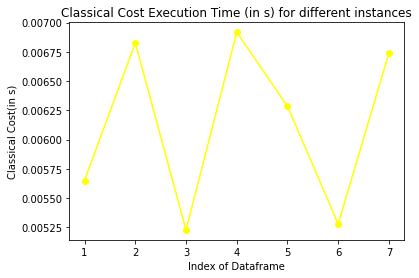

In [73]:
index1 = result_df_classical_cost.index
classical_cost_np_q_time = result_df_classical_cost['Classical Cost Execution Time (in s)'].to_numpy()
plt.plot(index1, classical_cost_np_q_time, marker='o', color='yellow')
plt.title('Classical Cost Execution Time (in s) for different instances')
plt.xlabel('Index of Dataframe')
plt.ylabel('Classical Cost(in s)')
plt.show()

In [111]:
import numpy as np
from scipy.interpolate import UnivariateSpline
    # pydoc scipy.interpolate.UnivariateSpline -- fitpack, unclear
from datetime import date
from pylab import *  # ipython -pylab


k=1 [4.33886629e-03 5.72192836e-03 6.30832119e-03 ... 1.18484691e+09
 1.18496543e+09 1.18508395e+09]


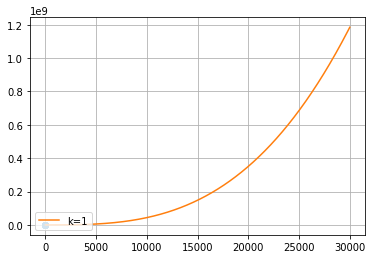

In [115]:


plt.plot( index1, classical_cost_np_q_time, "o" )
indexwanted = np.arange(0, 30000)

  # line parabola cubicspline
for k in range(1, 2, 3):
    extrapolator = UnivariateSpline( index1, classical_cost_np_q_time, k=3 )
    y1 = extrapolator( indexwanted )
    label = "k=%d" % k
    print (label, y1)
    plt.plot( indexwanted, y1, label=label  )
    
  # pylab

legend( loc="lower left" )
grid(True)
savefig( "extrapolate-UnivariateSpline.png", dpi=50 )
show()


## Quantum solution from the ground 

In [ ]:
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.algorithms import MinimumEigenOptimizer


class QuantumOptimizer:
    def __init__(self, instance, n, K):

        self.instance = instance
        self.n = n
        self.K = K

    def binary_representation(self, x_sol=0):

        instance = self.instance
        n = self.n
        K = self.K

        A = np.max(instance) * 100  # A parameter of cost function

        # Determine the weights w
        instance_vec = instance.reshape(n**2)
        w_list = [instance_vec[x] for x in range(n**2) if instance_vec[x] > 0]
        w = np.zeros(n * (n - 1))
        for ii in range(len(w_list)):
            w[ii] = w_list[ii]

        # Some variables I will use
        Id_n = np.eye(n)
        Im_n_1 = np.ones([n - 1, n - 1])
        Iv_n_1 = np.ones(n)
        Iv_n_1[0] = 0
        Iv_n = np.ones(n - 1)
        neg_Iv_n_1 = np.ones(n) - Iv_n_1

        v = np.zeros([n, n * (n - 1)])
        for ii in range(n):
            count = ii - 1
            for jj in range(n * (n - 1)):

                if jj // (n - 1) == ii:
                    count = ii

                if jj // (n - 1) != ii and jj % (n - 1) == count:
                    v[ii][jj] = 1.0

        vn = np.sum(v[1:], axis=0)

        # Q defines the interactions between variables
        Q = A * (np.kron(Id_n, Im_n_1) + np.dot(v.T, v))

        # g defines the contribution from the individual variables
        g = (
            w
            - 2 * A * (np.kron(Iv_n_1, Iv_n) + vn.T)
            - 2 * A * K * (np.kron(neg_Iv_n_1, Iv_n) + v[0].T)
        )

        # c is the constant offset
        c = 2 * A * (n - 1) + 2 * A * (K**2)

        try:
            max(x_sol)
            # Evaluates the cost distance from a binary representation of a path
            fun = (
                lambda x: np.dot(np.around(x), np.dot(Q, np.around(x)))
                + np.dot(g, np.around(x))
                + c
            )
            cost = fun(x_sol)
        except:
            cost = 0

        return Q, g, c, cost

    def construct_problem(self, Q, g, c) -> QuadraticProgram:
        qp = QuadraticProgram()
        for i in range(n * (n - 1)):
            qp.binary_var(str(i))
        qp.objective.quadratic = Q
        qp.objective.linear = g
        qp.objective.constant = c
        return qp

#     def solve_problem(self, qp):
#         algorithm_globals.random_seed = 10598
#         quantum_instance = QuantumInstance(
#             BasicAer.get_backend("qasm_simulator"),
#             seed_simulator=algorithm_globals.random_seed,
#             seed_transpiler=algorithm_globals.random_seed,
#         )

#         vqe = VQE(quantum_instance=quantum_instance)
#         optimizer = MinimumEigenOptimizer(min_eigen_solver=vqe)
#         result = optimizer.solve(qp)
#         # compute H
#         H, offset = optimizer._convert(qp, optimizer._converters).to_ising()
#         # _, _, _, level = self.binary_representation(x_sol=result.x)
#     # Instantiate the quantum optimizer class with parameters: 
algorithm_globals.massive=True
# Instantiate the quantum optimizer class with parameters: 
quantum_optimizer = QuantumOptimizer(instance, n, K)

try:
    if z is not None:
        Q, g, c, binary_cost = quantum_optimizer.binary_representation(x_sol = z)
    else:
        Q, g, c, binary_cost = quantum_optimizer.binary_representation()
except NameError as e:
    pass

qp = quantum_optimizer.construct_problem(Q, g, c)

quantum_instance = QuantumInstance(BasicAer.get_backend('qasm_simulator'),
                                           seed_simulator=algorithm_globals.random_seed,
                                           seed_transpiler=algorithm_globals.random_seed)

vqe = VQE(quantum_instance=quantum_instance)
optimizer = MinimumEigenOptimizer(min_eigen_solver=vqe)
H, offset = optimizer._convert(qp, optimizer._converters).to_ising()

        

In [47]:
def Ansatz(par, N, p=1):
    qc = QuantumCircuit(N)
    # Initial layer
    for i in range(N):
        qc.ry(par[i], i)
        
    for layer in range(p):
        par_counter = N+2*(N-1)*layer
    # Repeteable layer. To do the layer VQE thing, define this unit as a separate function
        for i in range(N//2):
            j = 2*i
            qc.cx(j, j+1)
            qc.ry(par[j+par_counter], j)
            qc.ry(par[j+1+par_counter], j+1)

        for i in range(N//2):
            j = 2*i
            if j+2<N: 
                qc.cx(j+1, j+2)
                qc.ry(par[N-N%2+j+1+par_counter], j+2)
                qc.ry(par[N-N%2+j+par_counter], j+1)
    return qc

We need to define some filtering operator. We will consider $F_\tau = \tau I - \mathcal{H}$ for a constant $\tau \ge E_\mathrm{max}$ since it's a very simple one that is indeed equivalent to a regular VQE. 

***

Next, we would have to define our objective function, which is

\begin{equation}
\begin{aligned}
\mathcal{C}_{t}(\boldsymbol{\theta}) &=\frac{1}{2} \||\psi(\boldsymbol{\theta})\rangle-\left|F_{t} \psi_{t-1}\right\rangle \|^{2} \\
&=1-\frac{\operatorname{Re}\left\langle\psi_{t-1}\left|F_{t}\right| \psi(\boldsymbol{\theta})\right\rangle}{\sqrt{\left\langle F_{t}^{2}\right\rangle_{\psi_{t-1}}}}
\end{aligned}
\end{equation}

However, given that the gradient descent update is written as

\begin{equation}
\boldsymbol{\theta}_{t}=\boldsymbol{\theta}_{t-1}-\left.\eta \sum_{j=1}^{m} \frac{\partial \mathcal{C}_{t}(\boldsymbol{\theta})}{\partial \theta_{j}}\right|_{\boldsymbol{\theta}_{t-1}} \boldsymbol{e}_{j},
\end{equation}

and we have an analytic expression for those derivatives

\begin{equation}
\left.\frac{\partial \mathcal{C}_{t}(\boldsymbol{\theta})}{\partial \theta_{j}}\right|_{\boldsymbol{\theta}_{t-1}}=-\frac{\left\langle F_{t}\right\rangle_{\psi_{t-1}^{j}}-\left\langle F_{t}\right\rangle_{\psi_{t-1}^{j-}}}{4 \sqrt{\left\langle F_{t}^{2}\right\rangle_{\psi_{t-1}}}},
\end{equation}

there is no need to evaluate that objective function $C_t(\theta)$.

***


In [36]:
def filtering_function6(E, c):
    return (c-E)

def bitstring_energy(H, bitstring):
    
    bitstring = bitstring[::-1]    
    #print(bitstring)
    spins = np.array([(-1)**(b == '1') for b in bitstring])
    #print(spins)
    value = 0
          
    for i, coef in enumerate(H.coeffs):
        #print("i is",i)
        weight = np.real(coef)
        indices = np.where(H.primitive.table.Z[i])
        #print("indices are:",indices[0])
        #print("------------")
        value += weight * np.prod(spins[indices])
    
    return value


def expectation(H,theta,n,l,shots,tau,filtering,power):
    
    circuit=Ansatz(theta,n,l)
    circuit.measure_all()
        
    backend = Aer.get_backend('qasm_simulator')
    job = execute(circuit, backend, shots=shots)
    result = job.result()
    counts = result.get_counts()

    F_exp=0
    for bit,prob in counts.items():
        
        if filtering ==True:
            if power==True:
                F_exp+=(prob*filtering_function6(bitstring_energy(H, bit), tau)**2)
            else:
                F_exp+=(prob*filtering_function6(bitstring_energy(H, bit), tau))
        else:
            F_exp+=(prob*energies[i])

    return F_exp/shots

def gradient(op, n,l, shots,tau):
    def gradient_fn(params):
        grad_list=[]
        num_params = len(params)
        
        # Here, we apply the parameter shift-rule
        param_sets_to_eval = params + np.concatenate(
        (
            np.eye(num_params) * np.pi / 2,  # copy of the parameters with the positive shift
            -np.eye(num_params) * np.pi / 2,
        ),  # copy of the parameters with the negative shift
        axis=0,)
        
        denominator=4*np.sqrt(expectation(op,params,n,l,shots,tau,True,True))
        for i in range(len(params)):
            numerator=expectation(op,param_sets_to_eval[i],n,l,shots,tau,True,False)-expectation(op,param_sets_to_eval[i+len(params)],n,l,shots,tau,True,False)
            grad_list.append(numerator/denominator)
        return np.array(grad_list)
    return gradient_fn

def qiskit_expectation(op,n,l,shots):
    def q_exp(theta):
        psi = CircuitStateFn(Ansatz(theta,n,l))
        # define your backend or quantum instance (where you can add settings)
        backend = Aer.get_backend('qasm_simulator') 
        q_instance = QuantumInstance(backend, shots=shots)
        # define the state to sample
        measurable_expression = StateFn(op, is_measurement=True).compose(psi) 
        # convert to expectation value
        expectation = PauliExpectation().convert(measurable_expression)  
        # get state sampler (you can also pass the backend directly)
        sampler = CircuitSampler(q_instance).convert(expectation) 
        ##print('Math:', psi.adjoint().compose(op).compose(psi).eval().real)
        # evaluate
        return sampler.eval().real
    return q_exp

 Callback function for cost values which later can be used for visualization purpose

In [37]:
num_qubits = 30
F = c * (I^H.num_qubits) - H
fvqe_cost, fvqe_iter=[],[]
def callback(nfevs, x_next, cost, stepsize):
    fvqe_cost.append(cost)
    fvqe_iter.append(nfevs)

FVQE algorithm

In [38]:
shots=1024
num_qubits = H.num_qubits
num_para=2*(num_qubits-1)# The number of parameters in each Layer (except Layer 0).
# a=H.to_matrix()
# R= np.real(a)
# E=np.linalg.eig(R)
layers=1
# print(E)





In [39]:
import time
start_time = time.time()
# quantum solution

theta= np.asarray([*((np.pi/2)*np.ones(num_qubits)),*(np.zeros(2*(num_qubits-1)*layers))])
optimizer = GradientDescent(maxiter=80,learning_rate=1.0, callback=callback)

obj = qiskit_expectation(H,num_qubits,layers,shots) # <H>

grad_fun = gradient(F, num_qubits,layers, shots,c)

result = optimizer.minimize(fun=obj, x0=theta,jac=grad_fun)
qc = Ansatz(result.x, num_qubits, layers)
qc.measure_all()
backend = Aer.get_backend('qasm_simulator')
job = execute(qc, backend, shots=shots)
res = job.result()
counts = res.get_counts()
revsol = counts.most_frequent()[::-1]
sol = np.array(list(revsol), dtype=int)
_,_,_,level = quantum_optimizer.binary_representation(x_sol=sol)
print("Quantum Cost is : ",level)
end_time=time.time() - start_time
tq = end_time
print(tq)


/tmp/ipykernel_1686/2340771346.py:15: DeprecationWarning: The SparsePauliOp.table method is deprecated as of Qiskit Terra 0.19.0 and will be removed no sooner than 3 months after the releasedate. Use SparsePauliOp.paulis method instead.
  indices = np.where(H.primitive.table.Z[i])


Quantum Cost is :  12.656201837646222
8.77724552154541


In [ ]:
print(level)
print("Quantum Cost execution time(in s) is : ",tq)

In [40]:
### Making a Dataframe of obtained results ###
def solutions_to_df(n, K, level):
    dfdata = np.array([n, K, level, tq])
    df = pd.DataFrame(data=dfdata, index=['n (No. of locations)', 'K (No. of vehicles)', 'Quantum Cost', 'Quantum Cost Execution Time (in s)']).transpose()
    return df

In [41]:
### Combining all the results into a single Dataframe and saving it as a file ###
filename = 'results_Quantum_cost.csv'
if os.path.isfile(filename): 

    result_df_Quantum_cost = pd.read_csv(filename)
    df_Quantum_cost = solutions_to_df(n, K, level) 
    result_df_Quantum_cost = result_df_Quantum_cost.append(df_Quantum_cost)
else:
    df_Quantum_cost = solutions_to_df(n, K, level)
    result_df_Quantum_cost = pd.DataFrame(df_Quantum_cost)
result_df_Quantum_cost.to_csv(filename)
result_df_Quantum_cost = result_df_Quantum_cost.drop(result_df_Quantum_cost.index[-1])
result_df_Quantum_cost[['n (No. of locations)', 'K (No. of vehicles)', 'Quantum Cost','Quantum Cost Execution Time (in s)']]
   

/tmp/ipykernel_1686/582485124.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df_Quantum_cost = result_df_Quantum_cost.append(df_Quantum_cost)


,n (No. of locations),K (No. of vehicles),Quantum Cost,Quantum Cost Execution Time (in s)
1,3.0,2.0,88.970629,78.932857
2,4.0,3.0,253.487492,743.703637
3,5.0,4.0,281.543155,6719.433259
4,5.0,4.0,281.543155,6719.433259
5,5.0,4.0,281.543155,6719.433259


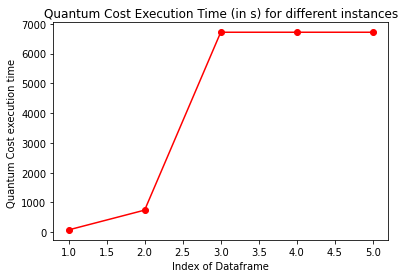

In [42]:
index2 = result_df_Quantum_cost.index
Quantum_cost_np_q_time = result_df_Quantum_cost['Quantum Cost Execution Time (in s)'].to_numpy()
plt.plot(index2, Quantum_cost_np_q_time, marker='o', color='red')
plt.title('Quantum Cost Execution Time (in s) for different instances')
plt.xlabel('Index of Dataframe')
plt.ylabel('Quantum Cost execution time ')
plt.show()


In [ ]:
plt.plot( index2, Quantum_cost_np_q_time, "o" )
indexwanted = np.arange(0, 30000)

  # line parabola cubicspline
extrapolator = UnivariateSpline( index2, Quantum_cost_np_q_time, k=2 )
y2 = extrapolator( indexwanted )
label = "k=%d" % k
print (label, y2)
plt.plot( indexwanted, y2, label=label  )  # pylab   

legend( loc="lower left" )
grid(True)
savefig( "extrapolate-UnivariateSpline.png", dpi=50 )
show()

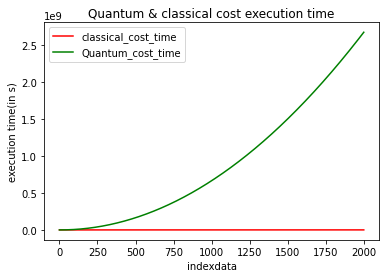

In [76]:
X = np.arange( 0, 3000)
Quantum_cost_np_q_time = result_df_Quantum_cost['Quantum Cost Execution Time (in s)'].to_numpy()
classical_cost_np_q_time = result_df_classical_cost['Classical Cost Execution Time (in s)'].to_numpy()

plt.plot(X, y1, color = 'red', label = 'classical_cost_time' )
plt.plot(X, y2, color = "green", label = 'Quantum_cost_time' )
plt.xlabel("indexdata")
plt.ylabel("execution time(in s)")
plt.title("Quantum & classical cost execution time")
  
# Adding legend, which helps us recognize the curve according to it's color
plt.legend()
  
# To load the display window
plt.show()